# Hybrid modelling for time series
Pablo Estrada & Soledad Coppiano (2018)

We make a comparison between traditional time series methods like ARIMA models, and novel approaches like Neural Networks. We propose a study case and emphasize the strenghtes and weaknesses of both methods.

In [1]:
# Importing libraries
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [9,5]
%matplotlib inline

import statsmodels.api as sm
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

## Quito Store

## Part 0: Load & visualize data
The data consists of retail stores' transactions. The stores are from Quito (44) and from Guayaquil (34).

** Loading data **

In [2]:
# load the dataset
store = 44
df_transactions = pd.read_csv(r'..\..\data\input\transaction{}.csv'.format(store), usecols=[0, 2], index_col=0)

# Using 2016 and above
df_transactions.index = df_transactions.index.to_datetime()
df_transactions = df_transactions[df_transactions.index.year>=2016]

In [3]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 588 entries, 2016-01-02 to 2017-08-15
Data columns (total 1 columns):
transactions    588 non-null int64
dtypes: int64(1)
memory usage: 9.2 KB


** Visualizing the Time Series **

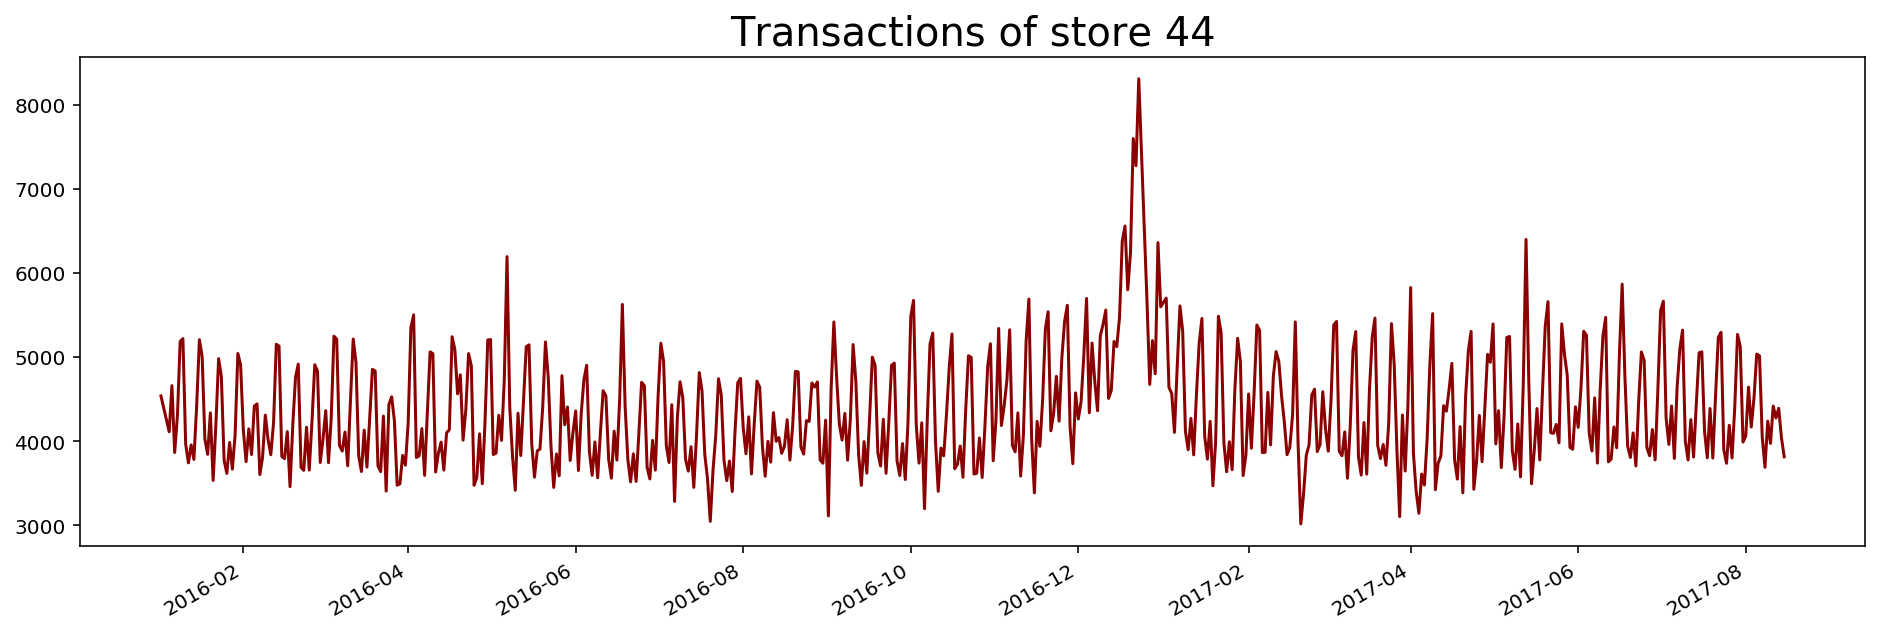

In [5]:
df_transactions["transactions"].plot(subplots=True, figsize=(16, 5), color="darkred")
plt.title('Transactions of store {}'.format(store), fontsize=20)
# plt.savefig('../figures/ts{}.png'.format(store), dpi=300, bbox_inches='tight')
plt.show()

## Part 1: Dynamic of the time series

** Autocorrelation Function for Moving Averages lags**

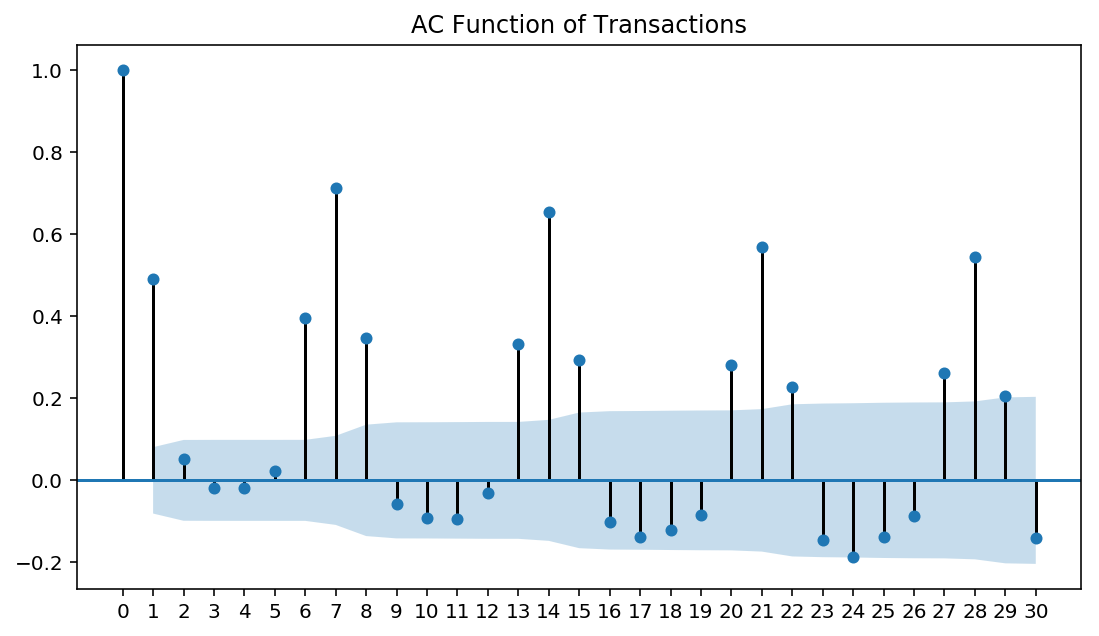

In [7]:
# Autocorrelation
fig, ax = plt.subplots(figsize=(9,5))
plot_acf(df_transactions, ax=ax, lags=30, title="AC Function of Transactions")
plt.xticks(np.arange(0, 31, 1))
plt.show()

First lag is significant, and it is posible that we have stationality

** Partial Autocorrelation Function for Lagged Dependent Variable**

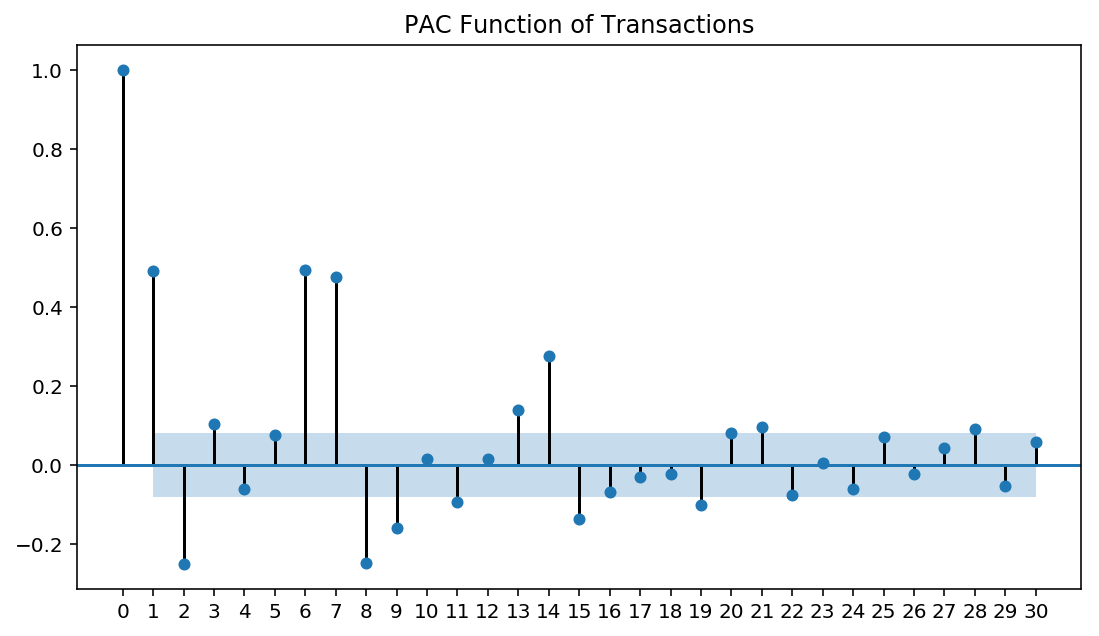

In [8]:
# Partial Autocorrelation
fig, ax = plt.subplots(figsize=(9,5))
plot_pacf(df_transactions, ax=ax, lags=30, title="PAC Function of Transactions")
plt.xticks(np.arange(0, 31, 1))
plt.show()

The first 2 lags are statistically significant, but there is stationality

** Decompose of trends, seasonality and noise **

These are the components of a time series
* Trend - Consistent upwards or downwards slope of a time series
* Seasonality - Clear periodic pattern of a time series(like sine funtion)
* Noise - Outliers or missing values

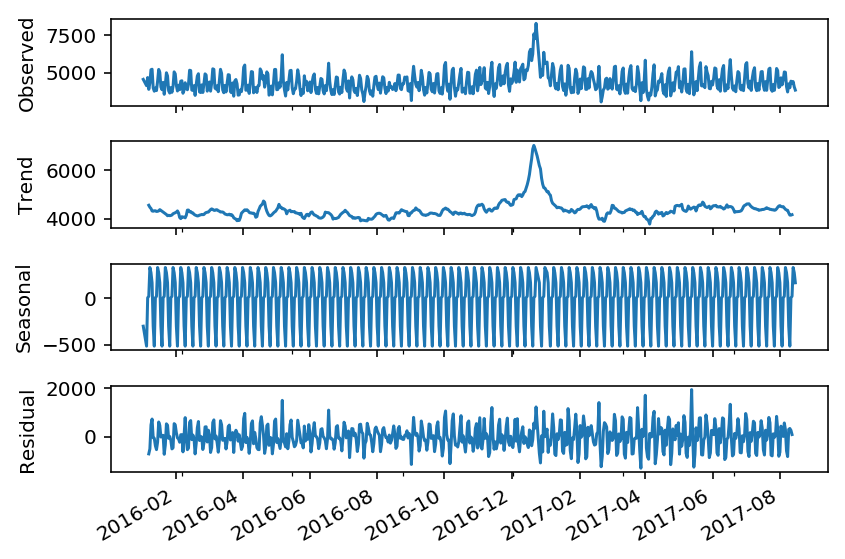

In [9]:
# Now, for decomposition...
decomposed = sm.tsa.seasonal_decompose(df_transactions.transactions,freq=7) # The frequncy is annual
figure = decomposed.plot()
plt.show()

## Part 2: Test and Models

** Augmented Dickey–Fuller test (ADF) **

An augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. It is basically Dickey-Fuller test with more lagged changes on RHS.

In [10]:
def test_stationarity(timeseries, ajuste=7):

    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=ajuste)
    rolstd = pd.rolling_std(timeseries, window=ajuste)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(9, 5))
    orig = plt.plot(timeseries, color='cadetblue',label='Original')
    mean = plt.plot(rolmean, color='maroon', label='Rolling Mean')
    std = plt.plot(rolstd, color='darkslategray', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 

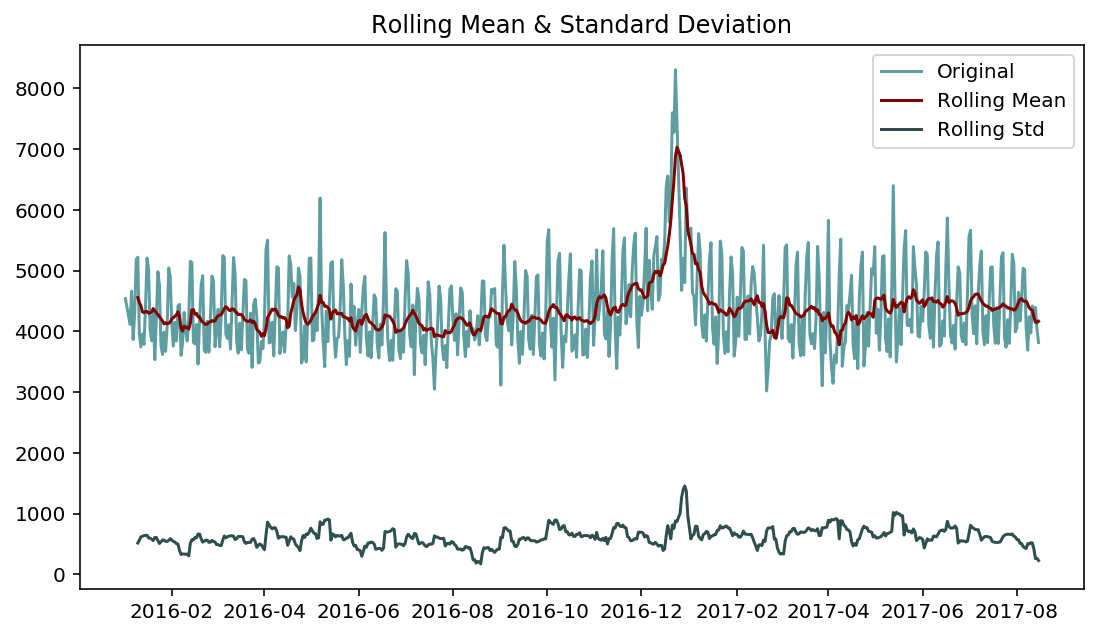

Results of Dickey-Fuller Test:
Test Statistic                  -3.481831
p-value                          0.008466
#Lags Used                      19.000000
Number of Observations Used    568.000000
Critical Value (1%)             -3.441915
Critical Value (5%)             -2.866642
Critical Value (10%)            -2.569487
dtype: float64


In [12]:
test_stationarity(df_transactions.transactions)

We reject the nule hipotesis, we have a stationary time series.

** Prediction using ARIMA model **

The idea is to have a function that evaluates all the posible combinations of the Seasonal ARIMA model. 

It is still in development fase. 

That's why it is commented the whole function.

In [94]:
# def evaluate_sarima(y, pdq, seasonal_pdq):
#     y = y.astype('float32')
#     train_size = int(len(y) * 0.80)
#     train, test = y[0:train_size], y[train_size:]
#     best_score, best_pdq, best_spdq = float("inf"), None, None
                           
#     for param in pdq:
#         for param_seasonal in seasonal_pdq:
#             try:
#                 model = sm.tsa.statespace.SARIMAX(train,
#                                                 order=param,
#                                                 seasonal_order=param_seasonal
#                                                 #enforce_stationarity=False,
#                                                 #enforce_invertibility=False
#                                                  )

#                 results = model.fit()
                
#                 prediction = results.get_prediction(start=train_size, dynamic=False)
#                 forecast = prediction.predicted_mean
#                 rmse = np.sqrt(mean_squared_error(test, forecast))
#                 print('ARIMA{}x{} - BIC:{.3f} - RMSE:{.3f}'.format(param, param_seasonal, results.bic, rmse))
#                 if rmse < best_score:
#                     best_score, best_pdq, best_spdq = rmse, param, param_seasonal
#             except:
#                 continue
#     print('Best SARIMA %s %s RMSE=%.3f' % (best_pdq, best_spdq, best_score))

In [99]:
# import itertools

# # Define the p, d and q parameters to take any value between 0 and 2
# p = range(1, 3)
# q = range(0, 2)
# d = range(1, 3)

# # Generate all different combinations of p, q and q triplets
# pdq = list(itertools.product(p, d, q))

# # Generate all different combinations of seasonal p, q and q triplets
# seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

Together these three parameters account for seasonality, trend, and noise in datasets:

* p: is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
* d: is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
* q: is the moving average part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.

When dealing with seasonal effects, we make use of the seasonal ARIMA, which is denoted as ARIMA(p,d,q)(P,D,Q)s. Here, (p, d, q) are the non-seasonal parameters described above, while (P, D, Q) follow the same definition but are applied to the seasonal component of the time series. The term s is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

The process is pretty straightforward. 
1. First I have to be sure that my time serie is float type.
2. I divide my sample in training data and test data.
3. Then I construct a Seasonal ARIMA model, I have to choose between multiple parameters (the explanation is below).

In [11]:
y = df_transactions["transactions"].astype(float)
train_size = int(len(y) * 0.70)
train, test = y[0:train_size].values, y[train_size:].values
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(2, 1, 1),
                                seasonal_order=(1, 0, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5561      0.033     16.650      0.000       0.491       0.622
ar.L2          0.0880      0.032      2.793      0.005       0.026       0.150
ma.L1         -1.0000      0.048    -21.006      0.000      -1.093      -0.907
ar.S.L7        0.9495      0.019     50.972      0.000       0.913       0.986
ma.S.L7       -0.5740      0.037    -15.671      0.000      -0.646      -0.502
sigma2      1.503e+05   3.17e-07   4.74e+11      0.000     1.5e+05     1.5e+05


All my estimated coefficients are statiscally significant at 95% of confidence.

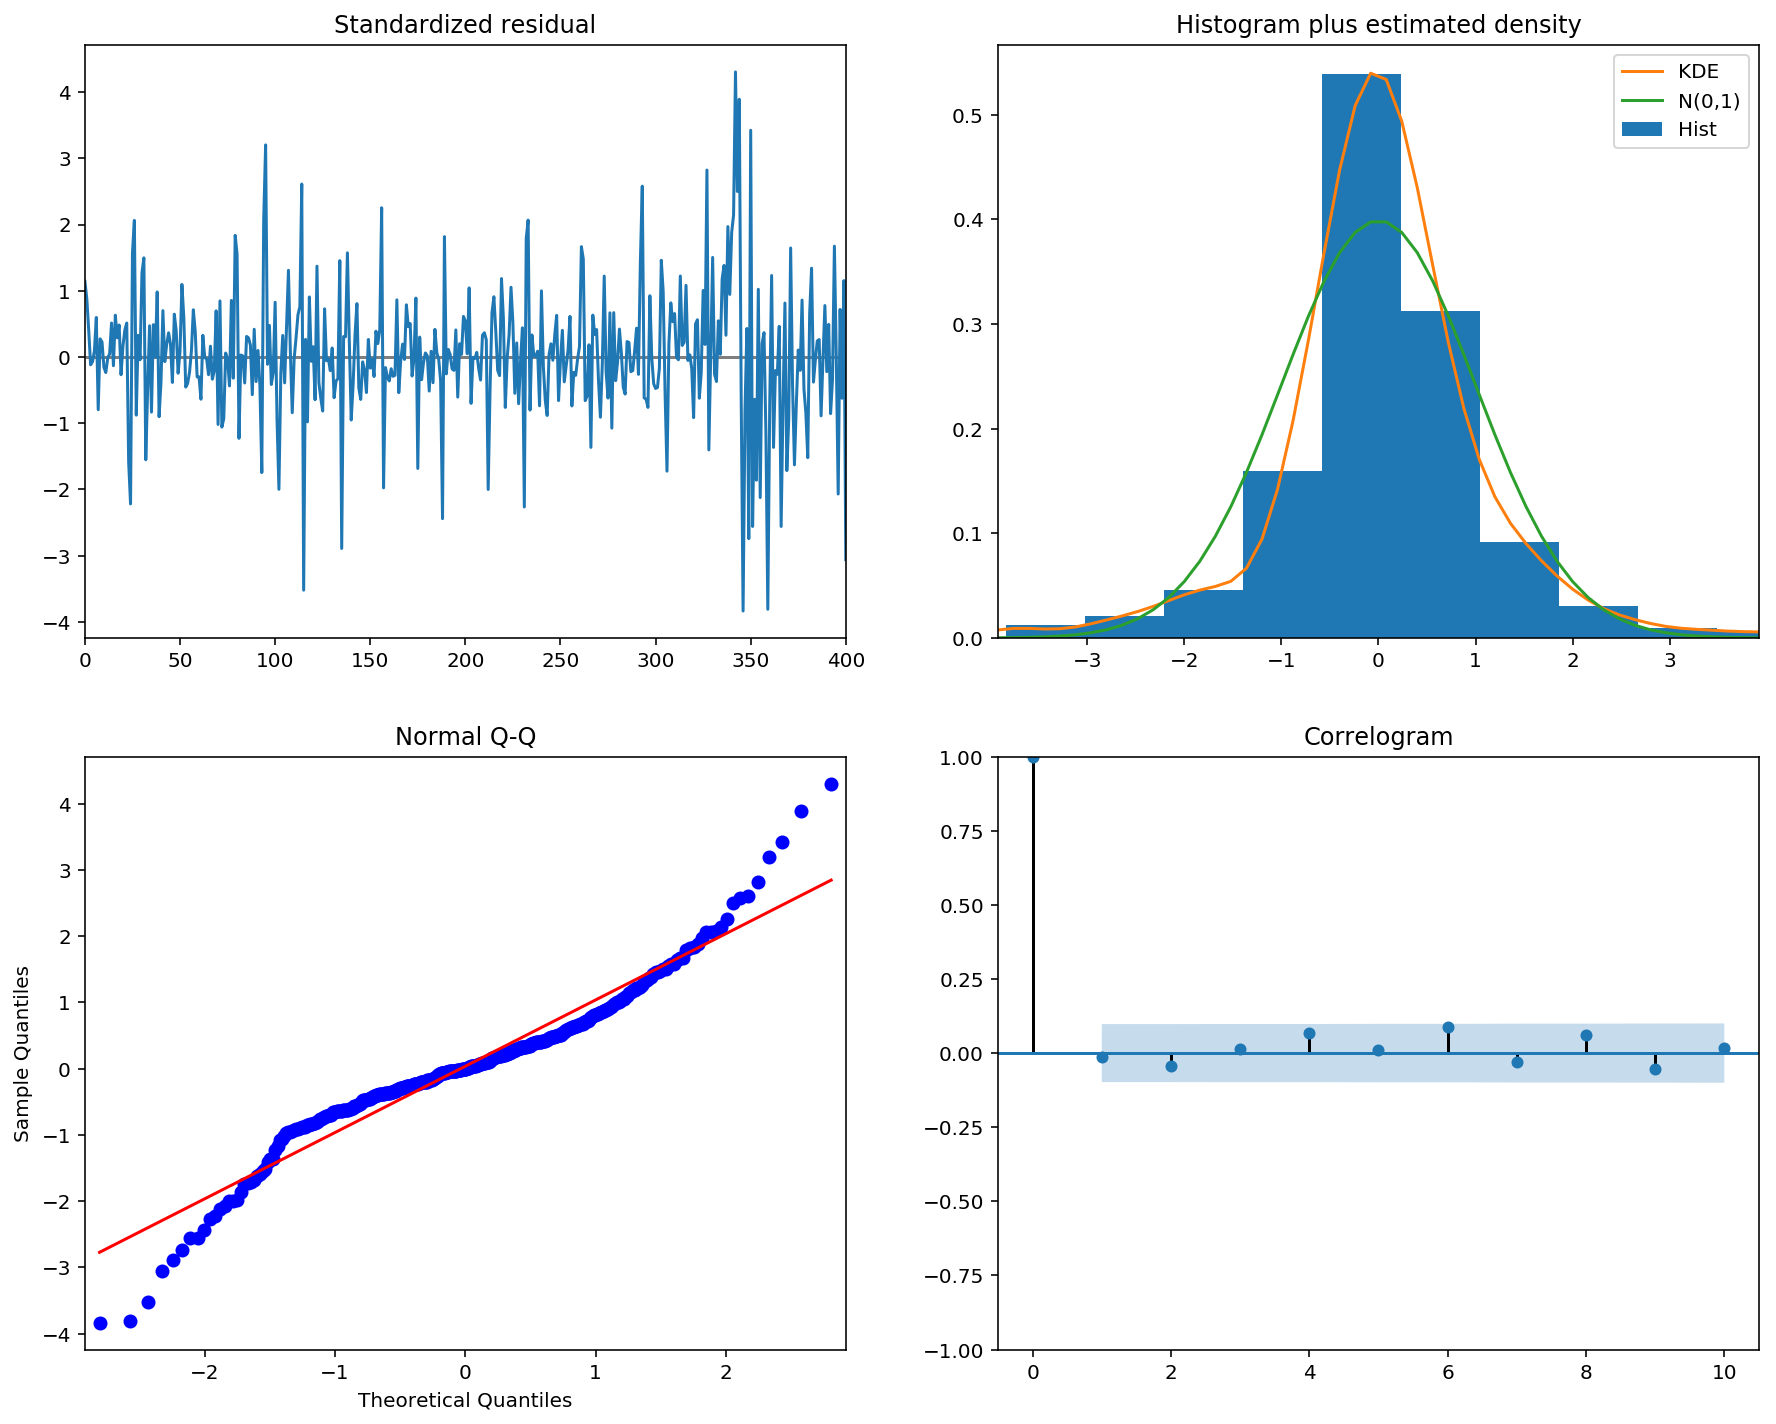

In [64]:
results.plot_diagnostics(figsize=(15, 12))
# plt.savefig('../figures/resid_sarima{}.png'.format(store), dpi=300, bbox_inches='tight')
plt.show()

It seems that the residuals are white noise.

## Part 3: Forecast Seasonal ARIMA

In order to compare the models, we are going to compute the RMSE.

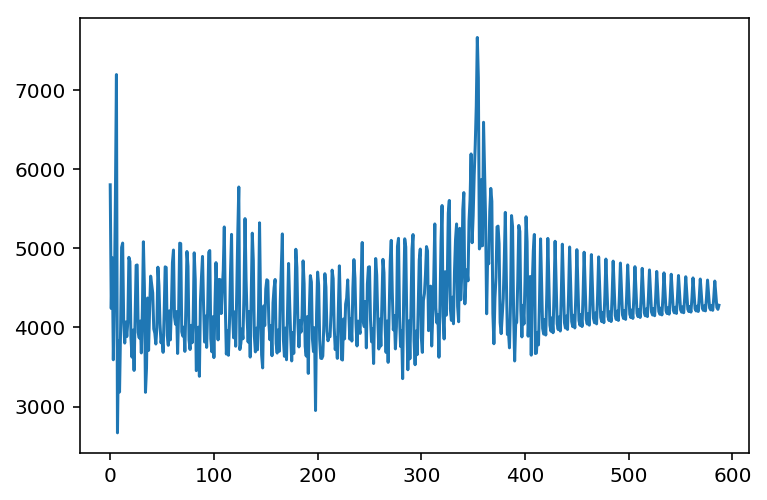

In [17]:
plt.plot(results.predict(start=1, end=len(df_transactions.index)))

In [7]:
# Get forecast n steps ahead in future
prediction = results.get_forecast(steps=len(test))
y_pred = pd.Series(prediction.predicted_mean, index=y[train_size:].index)
# Get confidence intervals of forecasts
prediction_ci = prediction.conf_int()
prediction_ci.index = y[train_size:].index
# Get RMSE
rmse = np.sqrt(mean_squared_error(test, y_pred))
print('RMSE: {:.2f}'.format(rmse))

RMSE: 464.10


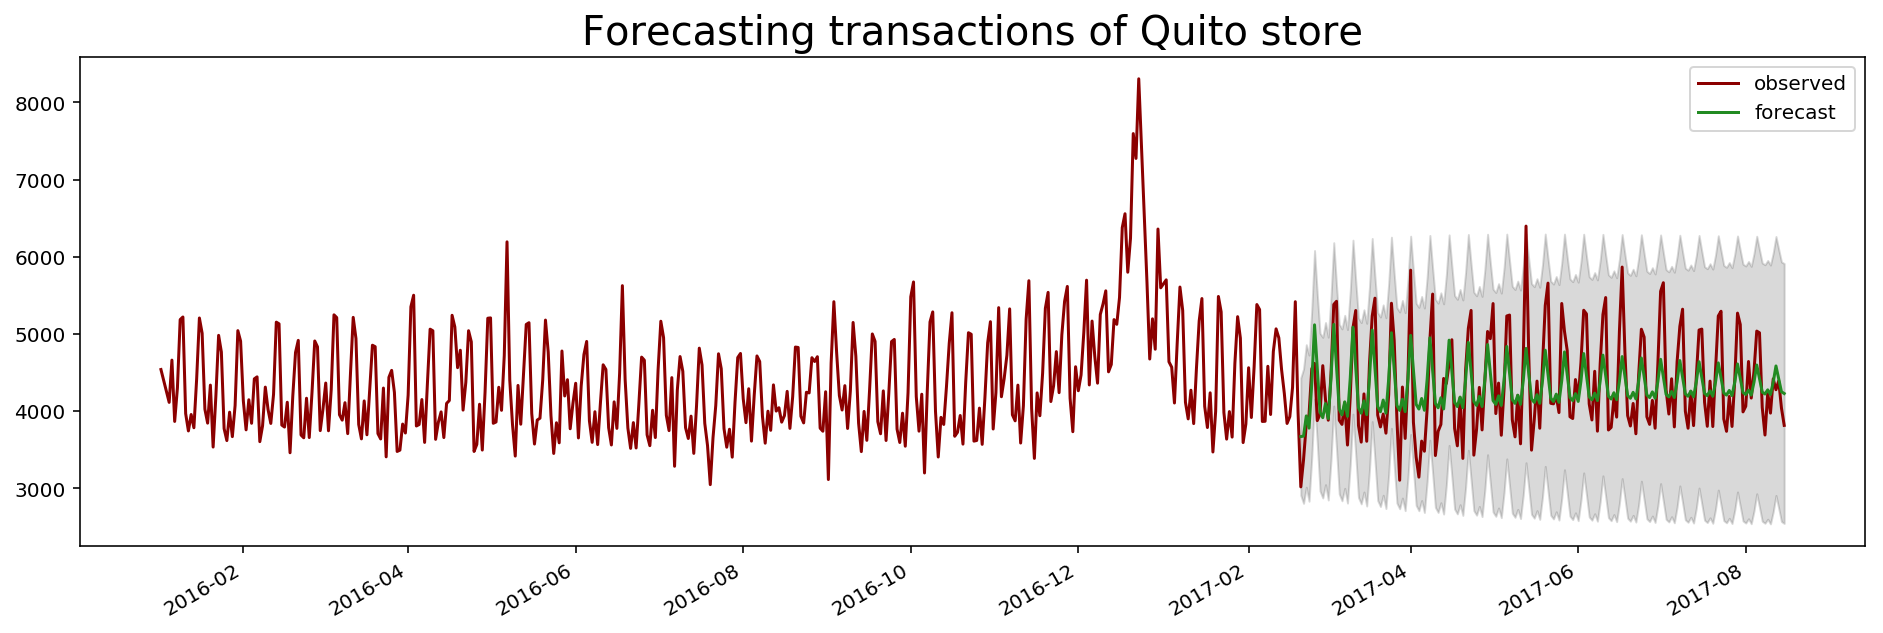

In [21]:
ax = y.plot(label='observed', figsize=(16, 5), color="darkred")
y_pred.plot(ax=ax, label='forecast', color="forestgreen")
ax.fill_between(prediction_ci.index,
                prediction_ci.iloc[:, 0],
                prediction_ci.iloc[:, 1], color='k', alpha=.15)
# ax.set_xlabel('Date', fontsize=15)
# ax.set_ylabel('Transactions', fontsize=15)
plt.title("Forecasting transactions of Quito store", fontsize=20)
plt.legend()
# plt.savefig('../figures/forecast_sarima{}.png'.format(store), dpi=300, bbox_inches='tight')
plt.show()

Saving errors to use them for the hybrid model.

In [70]:
error = y[1:] - results.predict(start=1, end=len(df_transactions.index)-1)
error.to_csv(r'..\..\data\output\error_sarima{}.csv'.format(store), index=False)

In [80]:
prediction_total = results.predict(start=1, end=len(df_transactions.index)-1)
y_pred_total = pd.Series(prediction_total, index=y[1:].index)
y_pred_total.to_csv(r'..\..\data\output\y_pred_total_sarima{}.csv'.format(store))

In [81]:
y_pred.to_csv(r'..\..\data\output\y_pred_sarima{}.csv'.format(store))